In [314]:
# Run this code if you get errors with missing requirements
import sys
!{sys.executable} -m pip install mysql-connector

import pandas as pd
import mysql.connector

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)


# Leikataan X arvoa hieman enemmä että latausasemat ei vaikuta ruuhkaan

In [315]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x, y FROM SensorData WHERE timestamp > '2019-05-28 04:00:08.078133+00:00' AND timestamp < '2019-05-28 20:00:08.078133+00:00'  AND x > 1000  AND X < 10406 AND y < 5220 AND y > 0  AND z = 0");
database = pd.DataFrame(mycursor.fetchall())
print(database)

       node_id                            timestamp     x     y
0        51735  b'2019-05-28 04:00:10.995581+00:00'  7639  2379
1        51735  b'2019-05-28 04:00:11.995528+00:00'  7639  2379
2        51735  b'2019-05-28 04:00:12.995463+00:00'  7635  2381
3        51735  b'2019-05-28 04:00:13.995619+00:00'  7635  2381
4        51735  b'2019-05-28 04:00:14.995508+00:00'  7635  2382
...        ...                                  ...   ...   ...
70441    51719   b'2019-05-28 17:11:57.98686+00:00'  1325  1299
70442    51719  b'2019-05-28 17:11:58.986779+00:00'  1233  1332
70443    51719  b'2019-05-28 17:11:59.987244+00:00'  1102  1409
70444    51719  b'2019-05-28 17:12:00.986703+00:00'  1030  1425
70445    51719  b'2019-05-28 19:10:19.987829+00:00'  1675  2662

[70446 rows x 4 columns]


# Tehdään uusi taulu ja laitetaan sinne node_id.

In [316]:

nodes = pd.DataFrame()

nodes['node_id'] = database['node_id']

print(nodes)


       node_id
0        51735
1        51735
2        51735
3        51735
4        51735
...        ...
70441    51719
70442    51719
70443    51719
70444    51719
70445    51719

[70446 rows x 1 columns]


# Laitetaan timestamppi tauluun ja poistetaan siitä turhat

In [317]:
nodes['timestamp'] = database['timestamp'].astype(str)
nodes['timestamp'] = nodes['timestamp'].str.slice(2, -7)
print(nodes)

       node_id                   timestamp
0        51735  2019-05-28 04:00:10.995581
1        51735  2019-05-28 04:00:11.995528
2        51735  2019-05-28 04:00:12.995463
3        51735  2019-05-28 04:00:13.995619
4        51735  2019-05-28 04:00:14.995508
...        ...                         ...
70441    51719   2019-05-28 17:11:57.98686
70442    51719  2019-05-28 17:11:58.986779
70443    51719  2019-05-28 17:11:59.987244
70444    51719  2019-05-28 17:12:00.986703
70445    51719  2019-05-28 19:10:19.987829

[70446 rows x 2 columns]


# Muutetaan timestamp datetime64 muotoon ja pyörristetään tunnin tarkkuudelle

In [318]:
nodes['timestamp'] = nodes['timestamp'].astype('datetime64[ns]')
nodes['timestamp'] = pd.Series(nodes['timestamp']).dt.round("H")
print(nodes)

       node_id           timestamp
0        51735 2019-05-28 04:00:00
1        51735 2019-05-28 04:00:00
2        51735 2019-05-28 04:00:00
3        51735 2019-05-28 04:00:00
4        51735 2019-05-28 04:00:00
...        ...                 ...
70441    51719 2019-05-28 17:00:00
70442    51719 2019-05-28 17:00:00
70443    51719 2019-05-28 17:00:00
70444    51719 2019-05-28 17:00:00
70445    51719 2019-05-28 19:00:00

[70446 rows x 2 columns]


# Tehdään timestampeista indexejä ja poistetaan entinen timestamp 


In [319]:
nodes.index = nodes['timestamp']

nodes = nodes.drop('timestamp', axis=1)
print(nodes)


                     node_id
timestamp                   
2019-05-28 04:00:00    51735
2019-05-28 04:00:00    51735
2019-05-28 04:00:00    51735
2019-05-28 04:00:00    51735
2019-05-28 04:00:00    51735
...                      ...
2019-05-28 17:00:00    51719
2019-05-28 17:00:00    51719
2019-05-28 17:00:00    51719
2019-05-28 17:00:00    51719
2019-05-28 19:00:00    51719

[70446 rows x 1 columns]


# Lasketaan kaikki samat tuntimäärät yhteen

In [320]:
nodes = nodes.resample('H').count()
print(nodes)

                     node_id
timestamp                   
2019-05-28 04:00:00     1287
2019-05-28 05:00:00      114
2019-05-28 06:00:00        0
2019-05-28 07:00:00     4084
2019-05-28 08:00:00     5430
2019-05-28 09:00:00     6564
2019-05-28 10:00:00     7311
2019-05-28 11:00:00     7743
2019-05-28 12:00:00    13045
2019-05-28 13:00:00     8851
2019-05-28 14:00:00     4796
2019-05-28 15:00:00     1967
2019-05-28 16:00:00     8040
2019-05-28 17:00:00     1213
2019-05-28 18:00:00        0
2019-05-28 19:00:00        1


# Tehdään 'esiintyvyysprosentti' dataframeen

In [321]:
nodes['esintyvyysprosentti'] = 100 * (nodes['node_id'] / nodes['node_id'].sum())
print(nodes)


                     node_id  esintyvyysprosentti
timestamp                                        
2019-05-28 04:00:00     1287             1.826931
2019-05-28 05:00:00      114             0.161826
2019-05-28 06:00:00        0             0.000000
2019-05-28 07:00:00     4084             5.797348
2019-05-28 08:00:00     5430             7.708032
2019-05-28 09:00:00     6564             9.317775
2019-05-28 10:00:00     7311            10.378162
2019-05-28 11:00:00     7743            10.991398
2019-05-28 12:00:00    13045            18.517730
2019-05-28 13:00:00     8851            12.564234
2019-05-28 14:00:00     4796             6.808052
2019-05-28 15:00:00     1967             2.792210
2019-05-28 16:00:00     8040            11.412997
2019-05-28 17:00:00     1213             1.721886
2019-05-28 18:00:00        0             0.000000
2019-05-28 19:00:00        1             0.001420


# Poistetaan vuodet, kuukaudet ja päivät index-timestampista, lisätään se otsikkoon seuraavassa vaiheessa

In [322]:
nodes.index = nodes.index.astype(str)
nodes.index = nodes.index.str.slice(10, -6)
print(nodes)

           node_id  esintyvyysprosentti
timestamp                              
 04           1287             1.826931
 05            114             0.161826
 06              0             0.000000
 07           4084             5.797348
 08           5430             7.708032
 09           6564             9.317775
 10           7311            10.378162
 11           7743            10.991398
 12          13045            18.517730
 13           8851            12.564234
 14           4796             6.808052
 15           1967             2.792210
 16           8040            11.412997
 17           1213             1.721886
 18              0             0.000000
 19              1             0.001420


# Muutetaan indexi numeraaliseksi ja lisätään aikavyöhykkeen takia +2 jokaiseen

In [323]:
nodes.index = nodes.index.astype(int)
nodes.index = nodes.index + 2

# Testaan... Pitäis varmaa paremmalla tavalla saada muutettua nämäkin
nodes['esintyvyysprosentti'].values[15] = nodes['esintyvyysprosentti'].values[13]
nodes['esintyvyysprosentti'].values[14] = nodes['esintyvyysprosentti'].values[12]
nodes['esintyvyysprosentti'].values[13] = nodes['esintyvyysprosentti'].values[11]
nodes['esintyvyysprosentti'].values[12] = nodes['esintyvyysprosentti'].values[10]
nodes['esintyvyysprosentti'].values[11] = nodes['esintyvyysprosentti'].values[9]
nodes['esintyvyysprosentti'].values[10] = nodes['esintyvyysprosentti'].values[8]
nodes['esintyvyysprosentti'].values[9]  = nodes['esintyvyysprosentti'].values[7]
nodes['esintyvyysprosentti'].values[8]  = nodes['esintyvyysprosentti'].values[6]
nodes['esintyvyysprosentti'].values[7]  = nodes['esintyvyysprosentti'].values[5]
nodes['esintyvyysprosentti'].values[6]  = nodes['esintyvyysprosentti'].values[4]
nodes['esintyvyysprosentti'].values[5]  = nodes['esintyvyysprosentti'].values[3]
nodes['esintyvyysprosentti'].values[4]  = nodes['esintyvyysprosentti'].values[2] 
nodes['esintyvyysprosentti'].values[3]  = nodes['esintyvyysprosentti'].values[1]
nodes['esintyvyysprosentti'].values[2]  = nodes['esintyvyysprosentti'].values[0]

 
print(nodes)

           node_id  esintyvyysprosentti
timestamp                              
6             1287             1.826931
7              114             0.161826
8                0             1.826931
9             4084             0.161826
10            5430             0.000000
11            6564             5.797348
12            7311             7.708032
13            7743             9.317775
14           13045            10.378162
15            8851            10.991398
16            4796            18.517730
17            1967            12.564234
18            8040             6.808052
19            1213             2.792210
20               0            11.412997
21               1             1.721886


# Pudotetaan aukiolon ulkopuolella olevat ajat

In [324]:
nodes = nodes.drop(index=6)
nodes = nodes.drop(index=7)

print(nodes)

           node_id  esintyvyysprosentti
timestamp                              
8                0             1.826931
9             4084             0.161826
10            5430             0.000000
11            6564             5.797348
12            7311             7.708032
13            7743             9.317775
14           13045            10.378162
15            8851            10.991398
16            4796            18.517730
17            1967            12.564234
18            8040             6.808052
19            1213             2.792210
20               0            11.412997
21               1             1.721886


# Plotataan kärryjen prosenttiosuus päivästä tunnettain

Text(0.5, 0, 'Kellonaika')

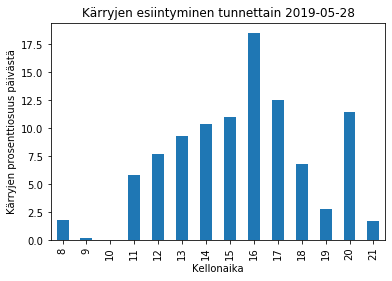

In [326]:
import pylab as plt

nodes.groupby("timestamp").esintyvyysprosentti.mean().plot.bar(title='Kärryjen esiintyminen tunnettain 2019-05-28')
plt.ylabel('Kärryjen prosenttiosuus päivästä')
plt.xlabel('Kellonaika')
